<a href="https://colab.research.google.com/github/ruddysimon/ADS504-machine-learning-deep-learning/blob/ruddy-branch/Fake_news_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import csv

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Data Understanding

In [2]:
fake_news_df = pd.read_csv("/content/drive/MyDrive/ADS504 - Machine Learning /resource/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [3]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

With 20,800 rows in your dataset, removing all rows with missing values would still leave a substantial amount of data. However, given that the "title" and "text" fields are likely very important for a fake news detection task, it may be better to avoid removing these rows if possible.

**Suggestion:**

For the "title" and "text" columns, replace missing values with a placeholder string such as "missing". This allows us to retain the rows while also acknowledging the absence of this important information.</br>
For the "author" column, replace missing values with another placeholder string like "unknown". The authorship may be less important in determining whether a news story is fake, so this approach allows us to keep the data without making potentially misleading assumptions.

In [4]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna("", inplace=True)
fake_news_df['text'].fillna("", inplace=True)

# replace NaN values in 'author' with 'unknown'
fake_news_df['author'].fillna('unknown', inplace=True)

In [5]:
# combine 'title' and 'text' into a one single variable
fake_news_df['content'] = fake_news_df['title'] + ' ' + fake_news_df['text']
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [6]:
# drop unnecessary column
fake_news_df.drop(["id"],axis=1,inplace=True)

## Class Imbalance check

1    10413
0    10387
Name: label, dtype: int64


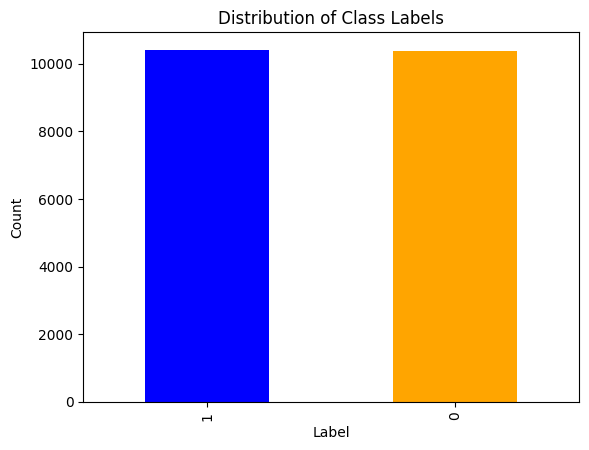

In [7]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar', color=['blue','orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

# Preprocessing

In [8]:
import spacy
import string

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Tokenize the text and remove stopwords
    words = [token.lemma_ for token in nlp(text) if not token.is_stop]

    # join the words back into a string
    return ' '.join(words)

# lowercase the text and remove punctuation
fake_news_df['content'] = fake_news_df['content'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

# apply the preprocessing to the 'content' column
fake_news_df['content'] = fake_news_df['content'].apply(preprocess_text)


Loading the SpaCy Model: SpaCy is a library in Python that is used for advanced Natural Language Processing. It comes with pre-trained models for various languages, including English, which can perform several NLP tasks. The line nlp = spacy.load('en_core_web_sm') loads the small English model and assigns it to the variable nlp. This model will be used for tokenization, lemmatization, and stop word identification.
Defining the Preprocessing Function: The preprocess_text function is defined to process a single piece of text (a news article in this case).
It starts by tokenizing the text, which involves breaking it down into individual words or "tokens". This is done by passing the text to the nlp model: nlp(text).
For each token, it checks if it is a stop word (common words like 'is', 'at', 'which', 'on', etc. that do not carry much meaningful information) using token.is_stop. If the token is not a stop word, it is lemmatized, which means it's reduced to its base or dictionary form. For example, "running" is lemmatized to "run", "better" is lemmatized to "good". This is done using token.lemma_.
The resulting words, which have been filtered for stop words and lemmatized, are then joined back together into a single string using ' '.join(words).
Lowercasing and Removing Punctuation: Before applying the preprocess_text function to the 'content' column, the text is first converted to lowercase using str.lower(). This is done because in text analysis, typically the case of the words is not important. 'Word' and 'word' would be considered as different words by the computer, hence we convert everything to lowercase to avoid duplicating words based on case. The punctuation is also removed using str.translate(str.maketrans('', '', string.punctuation)), as punctuation usually doesn't carry meaningful information for text classification tasks.
Applying the Preprocessing Function: The preprocess_text function is applied to every article in the 'content' column using the apply() function. This returns a new series where each article has been tokenized, stop words have been removed, and remaining words have been lemmatized.
These steps are similar to NLTK preprocessing in their goals (tokenization, stop word removal, lemmatization), but use the SpaCy library instead. The main difference is that SpaCy performs these steps using a single model and is generally faster and more efficient. Also, the lemmatization in SpaCy is more advanced and accurate compared to NLTK, as it takes into account the morphological analysis of the words to perform lemmatization.

In [17]:
fake_news_df.to_csv('/content/drive/MyDrive/ADS504 - Machine Learning /resource/preprocessed_data.csv',index=False)

# Data Partitioning

In [20]:
# data splitting
train_X, test_X, train_y, test_y = train_test_split(fake_news_df['content'], fake_news_df['label'],
                                                    test_size=0.2, random_state = 42)

# Text Tokenizer

In [22]:
# initialize the tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

tokenizer.fit_on_texts(train_X)

# tokenize the training and test data
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# padding the sequences
train_padded = pad_sequences(train_sequences, padding='post')
test_padded = pad_sequences(test_sequences, padding='post', maxlen=train_padded.shape[1])

train_padded

array([[14393,   551,   759, ...,     0,     0,     0],
       [ 3709,  2878,  2307, ...,     0,     0,     0],
       [   27,    10,   246, ...,     0,     0,     0],
       ...,
       [  137,   470,  1734, ...,     0,     0,     0],
       [  152,   857,   908, ...,     0,     0,     0],
       [    1,  9877,  1091, ...,     0,     0,     0]], dtype=int32)